In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as P
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gwsurrogate
from scipy.interpolate import InterpolatedUnivariateSpline as spline

from tqdm import tqdm

In [7]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
trunc_sur = gwsurrogate.LoadSurrogate('../TruncatedSurrogate/NRHybSur3dq8.h5')

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model
Loaded NRHybSur3dq8 model


In [4]:
# --------------------------------------------------------------------------
def spline_interp(newX, oldX, oldY):
    if len(oldY) != len(oldX):
        raise Exception('Lengths dont match.')

    if np.min(newX) < np.min(oldX) or np.max(newX) > np.max(oldX):
        print (newX[0], oldX[0], newX[-1], oldX[-1])
        raise Exception('Trying to extrapolate, disabled for now')

    newY = spline(oldX, oldY, ext=1)(newX)      # returns 0 when extrapolating
    return newY

# --------------------------------------------------------------------------
def interpolate_coorbital_frame_data(t_sparse, hCoOrb_sparse, t_new):
    hCoOrb = {}
    for key in hCoOrb_sparse.keys():
        data = hCoOrb_sparse[key]
        if np.iscomplexobj(data):
            hCoOrb[key] = \
                spline_interp(t_new, t_sparse, np.real(data)) \
                +1.j*spline_interp(t_new, t_sparse, np.imag(data))
        else:
            hCoOrb[key] = spline_interp(t_new, t_sparse, data)
    return hCoOrb  

#-----------------------------------------------------------------------------
def transform_to_coorbital_frame(t, hdict):
    """ Transforms from inertial frame to coorbital frame.

    Returns coorbital frame waveform modes as a dictionary, hCoOrb_dict.
    Usage:
        Amp_l2m2 = hCoOrb_dict['Amp_l2m2']
        phi_l2m2 = hCoOrb_dict['phi_l2m2']
        hCoOrb_l3m1 = hCoOrb_dict['hCoOrb_l3m1']    # similar for all other modes
    """

    h_22 = hdict[(2,2)]
    Amp_22 = np.abs(h_22)
    phi_22 = -np.unwrap(np.angle(h_22))

    # save coorbital frame strain as a dict
    hCoOrbdict = {}
    hCoOrbdict['Amp_l2m2'] = Amp_22
    hCoOrbdict['phi_l2m2'] = phi_22

    for mode in hdict.keys():
        l,m = mode
        if not (l==2 and m==2):     # for (2,2) mode we save Amp,phase instead
            hlm = hdict[(l,m)]
            hCoOrbdict['hCoOrb_l%dm%d'%(l,m)] = hlm*np.exp(1j*m*phi_22/2.)
                
    # Set initial phase to zero
    hCoOrbdict['phi_l2m2'] -= hCoOrbdict['phi_l2m2'][0]

    if np.max(np.abs((h_22*np.exp(1j*2*phi_22/2.)).imag)) > 1e-6:
        raise Exception('Imag part of 2,2 mode in coorbital frame should be 0 for nonprecessing cases.')

    return hCoOrbdict

# --------------------------------------------------------------------------
def transform_to_inertial_frame(hCoOrbdict):
    """ Transforms from coorbital frame to inertial frame.
    """
    hdict = {}
    phi22 = hCoOrbdict['phi_l2m2']
    hdict[(2,2)] = hCoOrbdict['Amp_l2m2'] * np.exp(-1j*phi22)
    for key in hCoOrbdict.keys():
        if key[:2] == "hC":
            l = int(key.split('_l')[-1].split('m')[0])
            m = int(key.split('m')[-1])
            hdict[(l,m)] = hCoOrbdict[key]*np.exp(-1j*m*phi22/2.)
            
    return hdict 

# --------------------------------------------------------------------------
def evaluate_surrogates(M, q, chi1, chi2, dist_mpc, f_ref, f_low, dt):
    
    # evaluate waveform modes for full surrogate and transform to coorbital frame
    t, hdict, _ = sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=f_ref, \
        dist_mpc=dist_mpc, M=M, units='mks')
    hCoOrbdict = transform_to_coorbital_frame(t, hdict)
    
    # similarly, evaluate truncated surrogate and transform to coorbital frame
    t_trunc, hdict_trunc, _ = trunc_sur(q, chi1, chi2, dt=dt, f_low=f_low, \
        f_ref=f_ref, dist_mpc=dist_mpc, M=M, units='mks')
    hCoOrbdict_trunc = transform_to_coorbital_frame(t_trunc, hdict_trunc)
    
    # interpolate onto a common time array
    # extra caution to avoid extrapolation
    times = np.arange(max(t[1], t_trunc[1]), min(t[-2], t[-2]), dt)  
    hCoOrbdict = interpolate_coorbital_frame_data(t, hCoOrbdict, times)
    hCoOrbdict_trunc = interpolate_coorbital_frame_data(t_trunc, hCoOrbdict_trunc, times)
    
    # Set initial phase to zero
    hCoOrbdict['phi_l2m2'] -= hCoOrbdict['phi_l2m2'][0]
    hCoOrbdict_trunc['phi_l2m2'] -= hCoOrbdict_trunc['phi_l2m2'][0]
    
    return times, hCoOrbdict, hCoOrbdict_trunc

# --------------------------------------------------------------------------
def get_uniform_in_orbits_times(t, phi_orb, PTS_PER_ORBIT=5):
    """
    returns sparse time array such that there are PTS_PER_ORBIT points
    in each orbit.
    """
    # get number of orbits
    n_orbits = int(abs((phi_orb[-1] - phi_orb[0])/(2*np.pi)))

    # get sparse times such that there are PTS_PER_ORBIT points in each orbit
    n_pts = int(n_orbits*PTS_PER_ORBIT)
    phi_orb_sparse = np.linspace(phi_orb[0], phi_orb[-1], n_pts)
    t_sparse = np.interp(phi_orb_sparse, phi_orb, t)

    return t_sparse

# --------------------------------------------------------------------------
def add_noise_to_data_piece(data, data_trunc, idx_sparse):
    # Add Gaussian noise with sigma given by the diff
    # FIXME: idx_sparse is not used for now
    data_diff = data - data_trunc
    data_marg = data + np.random.normal(0, np.abs(data_diff))
    return data_marg

# --------------------------------------------------------------------------
def align_orbital_phase(hdict):
    init_orbphase = -np.angle(hdict[(2,2)][0])/2
    for mode in hdict.keys():
        l,m = mode
        hdict[(l,m)] = hdict[(l,m)] * np.exp(1j*m*init_orbphase)
    return hdict

# --------------------------------------------------------------------------
def NRHybSur3dq8_marg(M, q, chi1, chi2, dist_mpc=400, f_ref=20, f_low=20, \
        sampling_frequency=4096., incl=0, phi_ref=0):

    dt = 1./sampling_frequency
    
    # Get surrogate and truncated surrogate in coorbital frame
    times, hCoOrbdict, hCoOrbdict_trunc \
        = evaluate_surrogates(M, q, chi1, chi2, dist_mpc, f_ref, f_low, dt)
    
    #P.plot(times, hCoOrbdict['phi_l2m2'])
    #P.plot(times, hCoOrbdict_trunc['phi_l2m2'], '--')
    
    # use orbital phase to get sparse times such that there are 5 points per orbit
    # FIXME: This will oversample the post ringdown, so throw those away
    phi_orb = hCoOrbdict['phi_l2m2']/2
    t_sparse = get_uniform_in_orbits_times(times, phi_orb, PTS_PER_ORBIT=5)
    
    # get indices of times that are closest to t_sparse
    # NOTE: We could downsample by interpolating using splines. But if the
    # data becomes very long, this becomes expensive. So, instead we just 
    # find the incdices of times that are closest to t_sparse, which is just as 
    # valid a way to downsample, but very cheap!
    idx_sparse = np.searchsorted(times, t_sparse)

    # Get marginalized coorbital frame data
    hCoOrbdict_marg = {}
    for key in hCoOrbdict.keys():
        data = hCoOrbdict[key]
        data_trunc = hCoOrbdict_trunc[key]
        hCoOrbdict_marg[key] = add_noise_to_data_piece(data, data_trunc, idx_sparse)
    # Set initial phase to zero after marginalization
    hCoOrbdict_marg['phi_l2m2'] -= hCoOrbdict_marg['phi_l2m2'][0]
    
    # Transform to inertial frame
    hdict = transform_to_inertial_frame(hCoOrbdict)
    hdict_marg = transform_to_inertial_frame(hCoOrbdict_marg)
    
    # Align initial orbital phase for plots
    hdict = align_orbital_phase(hdict)
    hdict_marg = align_orbital_phase(hdict_marg)
    
    #P.plot(times, hdict[(2,2)])
    #P.plot(times, hdict_marg[(2,2)])

    # project modes following LAL convention
    h = sur._mode_sum(hdict, incl, np.pi/2 - phi_ref, fake_neg_modes=True)
    h_marg = sur._mode_sum(hdict_marg, incl, np.pi/2 - phi_ref, fake_neg_modes=True)
    
    return times, h, h_marg

# --------------------------------------------------------------------------
def simple_mismatch(h, x):
    """ Computes Mismatch without phase and time shift.
    h is Complex target waveform.
    x is Complex template waveform.
    Step size should be constant as we are approximating an intergral by a sum.
    """
    norm_h =  np.sqrt(np.real(np.sum(h*np.conj(h))))
    norm_x =  np.sqrt(np.real(np.sum(x*np.conj(x))))
    overlap = np.abs(np.sum(x*np.conj(h))/norm_h/norm_x)
    return 1 - overlap 

# -------------------------------------------------------------------------
def set_logticks(fig, ax, given_xticks=None):
    """ For histograms we use linear scale x but do np.log10 on the data.
        So, here we replace the xticks from x to 10^x. We only pick those
        x that are integers. Then add minor ticks with log scaling.
    """

    if given_xticks is not None:
        ax.set_xticks(given_xticks)

    old_xticks = ax.get_xticks()
    new_xtickLocs = []
    new_xtickLabels = []
    for old_xt in old_xticks:
        if old_xt%1 == 0:
            new_xt = int(old_xt)
            new_xtickLocs.append(new_xt)
            new_xtickLabels.append('$10^{%d}$'%new_xt)

    # reset major tick labels
    ax.set_xticks(new_xtickLocs)
    ax.set_xticklabels(new_xtickLabels)

    # add minor ticks with log scaling
    minor_tickLocs = np.array([])
    tmp_int = min(new_xtickLocs)
    while tmp_int < max(new_xtickLocs):
        minor_tickLocs = np.append(minor_tickLocs, \
            np.log10(np.arange(1,10,1)*10**(tmp_int)))
        tmp_int += 1
    minor_locator = mpl.ticker.FixedLocator(minor_tickLocs)
    ax.xaxis.set_minor_locator(minor_locator)


# ------------------------------------------------------------------------
def PlotHist(ax, data, binsize, label=None, color='b', lw=1, ls='solid', zorder=2):
    ax.hist(np.log10(np.abs(data)+1e-13), bins=binsize, \
        color=color, label=label, histtype='step', lw=lw, ls=ls, zorder=zorder)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


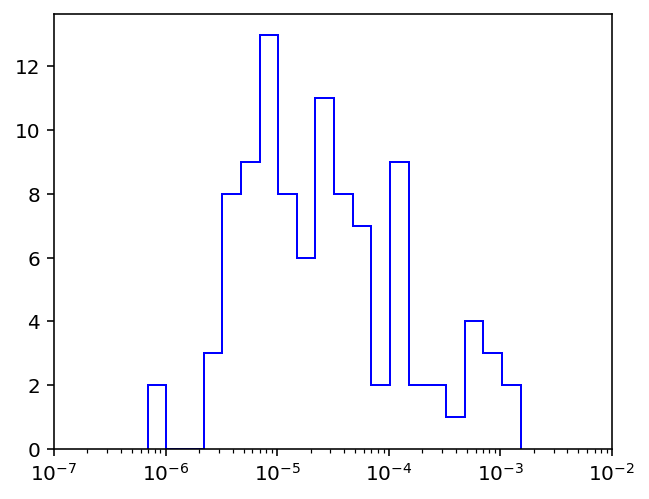

In [10]:
simple_mm = []
num = 100
#for idx in range(num):
for idx in tqdm(range(num)):
    M = np.random.uniform(60, 100)
    q = np.random.uniform(1, 8)
    chi1 = [0, 0, np.random.uniform(-0.8, 0.8)]
    chi2 = [0, 0, np.random.uniform(-0.8, 0.8)]
    incl = np.arccos(np.random.uniform(-1,1))
    t, h, h_marg = NRHybSur3dq8_marg(M, q, chi1, chi2, incl=incl)
    simple_mm.append(simple_mismatch(h, h_marg))

fig, ax = P.subplots(1,1,figsize=(5,4))
n_bins = 20
minX, maxX = -7, -2   # log10
ax.set_xlim(minX, maxX)
given_xticks = np.array(range(minX,maxX+1))
set_logticks(fig, ax, given_xticks=given_xticks)
PlotHist(ax, simple_mm, n_bins) 